### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.stattools import adfuller  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf, plot_acf, pacf, plot_pacf, seasonal_plot, month_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

### Reading in Data

In [2]:
bus = pd.read_csv('../brianna_folder/datasets/clean_bus_avg_ridership.csv')

In [3]:
bus.set_index(pd.DatetimeIndex(bus['month_beginning']), inplace=True)
bus.drop(columns=['month_beginning'], inplace=True)

In [4]:
bus.head()

,route_id,route_name,avg_weekday_rides,avg_saturday_rides,avg_sunday-holiday_rides,month_total
month_beginning,,,,,,
2001-01-01,1,Indiana/Hyde Park,6982.6,0.0,0.0,153617
2001-01-01,2,Hyde Park Express,1000.0,0.0,0.0,22001
2001-01-01,3,King Drive,21406.5,13210.7,8725.3,567413
2001-01-01,4,Cottage Grove,22432.2,17994.0,10662.2,618796
2001-01-01,6,Jackson Park Express,18443.0,13088.2,7165.6,493926


In [5]:
# Redefining dataframe to pre-pandemic ridership.

In [6]:
bus_pre_covid = bus[bus.index < '2020-03-01'].copy()

In [7]:
bus_pre_covid = bus_pre_covid.resample('MS', closed ='left').mean()

In [8]:
# Finding seasonality with acf and pacf

In [9]:
bus_pre_covid['1st_diff_total'] = bus_pre_covid['month_total'].diff(1)

In [10]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [11]:
interpret_dftest(adfuller(bus_pre_covid['month_total']))

Test Statistic   -1.928662
p-value           0.318700
dtype: float64

In [12]:
interpret_dftest(adfuller(bus_pre_covid['1st_diff_total'].dropna()))

Test Statistic   -3.558628
p-value           0.006603
dtype: float64

In [13]:
decomp_month_diff = seasonal_decompose(bus_pre_covid['1st_diff_total'].dropna(), period = 12)

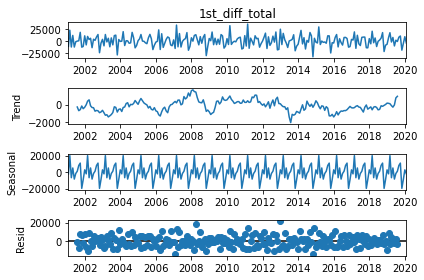

In [14]:
decomp_month_diff.plot();

In [15]:
decomp_month = seasonal_decompose(bus_pre_covid['month_total'], period = 12)

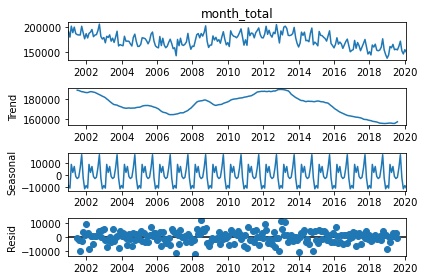

In [16]:
decomp_month.plot();

In [66]:
bus_pre_covid['lag_1'] = bus_pre_covid['1st_diff_total'].shift(1)
bus_pre_covid['lag_2'] = bus_pre_covid['1st_diff_total'].shift(2)
bus_pre_covid['lag_3'] = bus_pre_covid['1st_diff_total'].shift(3)

In [68]:
bus_pre_covid.corr()

,avg_weekday_rides,avg_saturday_rides,avg_sunday-holiday_rides,month_total,1st_diff_total,lag_1,lag_3,seasonal_12,time,lag_2
avg_weekday_rides,1.000000,0.763921,0.551060,0.897992,0.265468,0.290508,-0.213090,0.215254,-0.397501,0.142254
avg_saturday_rides,0.763921,1.000000,0.799238,0.815621,0.101417,0.215720,-0.045601,0.099098,-0.483201,0.114950
avg_sunday-holiday_rides,0.551060,0.799238,1.000000,0.674178,0.142985,0.211061,-0.032020,0.120241,-0.065477,0.077238
month_total,0.897992,0.815621,0.674178,1.000000,0.426061,0.183211,-0.029549,0.347320,-0.377970,0.154212
1st_diff_total,0.265468,0.101417,0.142985,0.426061,1.000000,-0.284878,-0.213831,0.738885,-0.004563,-0.043374
lag_1,0.290508,0.215720,0.211061,0.183211,-0.284878,1.000000,-0.044296,-0.091908,-0.001543,-0.284004
lag_3,-0.213090,-0.045601,-0.032020,-0.029549,-0.213831,-0.044296,1.000000,-0.247988,-0.003423,-0.282874
seasonal_12,0.215254,0.099098,0.120241,0.347320,0.738885,-0.091908,-0.247988,1.000000,-0.009818,-0.097540
time,-0.397501,-0.483201,-0.065477,-0.377970,-0.004563,-0.001543,-0.003423,-0.009818,1.000000,-0.007211
lag_2,0.142254,0.114950,0.077238,0.154212,-0.043374,-0.284004,-0.282874,-0.097540,-0.007211,1.000000


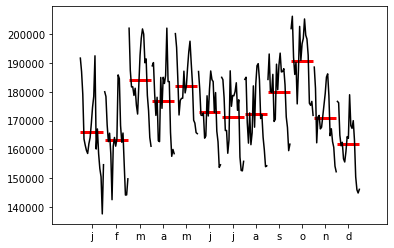

In [70]:
month_plot(bus_pre_covid['month_total']);
plt.savefig('./assets/monthplot_bus.png')

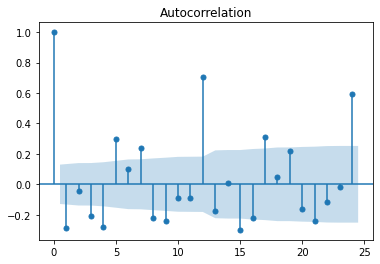

In [17]:
plot_acf(bus_pre_covid['1st_diff_total'].dropna(), lags=24);

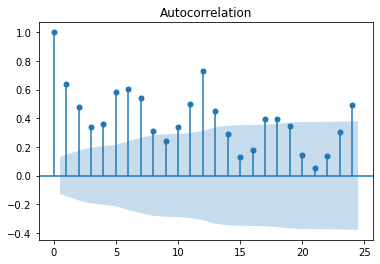

In [18]:
plot_acf(bus_pre_covid['month_total'], lags=24);

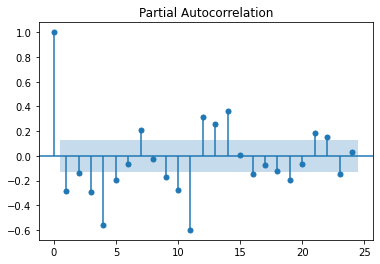

In [19]:
plot_pacf(bus_pre_covid['1st_diff_total'].dropna(), lags=24);

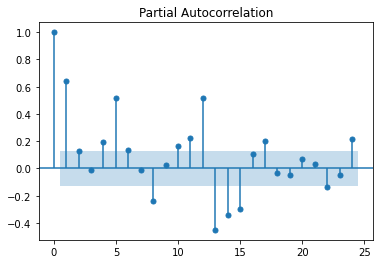

In [20]:
plot_pacf(bus_pre_covid['month_total'], lags=24);

In [21]:
# There is yearly seasonality and a downward trend.

In [23]:
# Creating columns for notable lags.

# Monthly
bus_pre_covid['lag_1'] = bus_pre_covid['1st_diff_total'].shift(1)

# Quarterly
bus_pre_covid['lag_3'] = bus_pre_covid['1st_diff_total'].shift(3)

# Yearly.
bus_pre_covid['seasonal_12'] = bus_pre_covid['1st_diff_total'].shift(12)

# Creating monthly index.
bus_pre_covid['time'] = range(0, bus_pre_covid.shape[0])

In [71]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(bus_pre_covid.drop(columns = ['month_total']),
                                                    bus_pre_covid['month_total'],
                                                    test_size = 0.25,
                                                    shuffle=False)

In [72]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(172, 9)
(58, 9)
(172,)
(58,)


In [73]:
# Linear Timeseries

In [74]:
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

y_train = y_train[X_train.index]

In [75]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [76]:
lm = sm.OLS(y_train, X_train)

In [77]:
lm_results = lm.fit()

In [78]:
lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            month_total   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     223.2
Date:                Sun, 22 Aug 2021   Prob (F-statistic):           8.85e-82
Time:                        22:09:49   Log-Likelihood:                -1507.7
No. Observations:                 159   AIC:                             3035.
Df Residuals:                     149   BIC:                             3066.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     2.677e+04   5702.642      4.694      0.000    1.55e+04     3.8e+04
avg_weekday_rides           15.9468      0.927     17.193      0.000      14.114      17.779
avg_saturday_rides           6.0623      1.986      3.053      0.003       2.139       9.986
avg_sunday-holiday_rides     5.1969      1.781      2.918      0.004       1.678       8.716
1st_diff_total               0.2793      0.037      7.626      0.000       0.207       0.352
lag_1                        0.0869      0.030      2.903      0.004       0.028       0.146
lag_3                        0.2641      0.024     10.961      0.000       0.216       0.312
seasonal_12                  0.1053      0.032      3.240      0.001       0.041       0.169
time                         3.9246      6.568      0.598      0.551      -9.054      16.903
lag_2                        0.1666      0.027      6.271      0.000       0.114       0.219
==============================================================================
Omnibus:                        2.939   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.230   Jarque-Bera (JB):                2.990
Skew:                          -0.311   Prob(JB):                        0.224
Kurtosis:                       2.744   Cond. No.                     3.67e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.67e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
lm_results.predict(X_test)

month_beginning
2015-05-01    187255.551852
2015-06-01    183102.613399
2015-07-01    171748.298339
2015-08-01    169895.285419
2015-09-01    186991.330815
2015-10-01    188162.936039
2015-11-01    163849.610403
2015-12-01    164730.283441
2016-01-01    158855.169514
2016-02-01    165470.940558
2016-03-01    176883.296407
2016-04-01    165435.223583
2016-05-01    174495.491016
2016-06-01    168185.947776
2016-07-01    156700.134183
2016-08-01    163027.953405
2016-09-01    176151.349165
2016-10-01    176444.408089
2016-11-01    163305.074759
2016-12-01    150766.789675
2017-01-01    153958.109965
2017-02-01    163456.954031
2017-03-01    170257.600792
2017-04-01    161332.480802
2017-05-01    172257.987952
2017-06-01    166022.161247
2017-07-01    152117.961742
2017-08-01    162012.055008
2017-09-01    173358.533167
2017-10-01    172527.703326
2017-11-01    162064.485513
2017-12-01    148757.848726
2018-01-01    150318.559972
2018-02-01    149749.506645
2018-03-01    165382.540428
2018

In [80]:
r2_score(y_test, lm_results.predict(X_test))

0.8953378354210386

In [81]:
mean_squared_error(y_test, lm_results.predict(X_test)) ** 0.5

3605.6643594458315

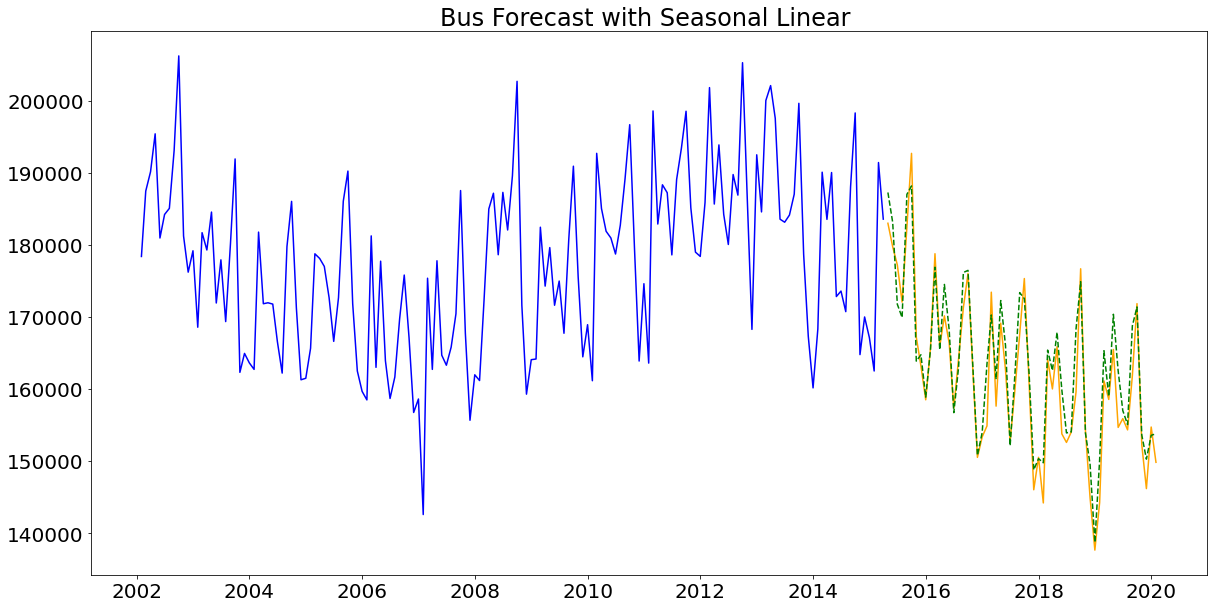

In [82]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'orange')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'green', ls='--')

# Set label.
plt.title(label = 'Bus Forecast with Seasonal Linear ', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
plt.savefig('./assets/linear_forecast_bus.png')